In [1]:
# 1. I import the modules I need
import os
import sys
from pathlib import Path

# 2. I add my project root so Python can find utils.py
project_root = Path().resolve()
sys.path.insert(0, str(project_root))

# 3. I double-check that I’m in the right directory
print("Project root:", project_root)
print("Contents:", os.listdir(project_root))

# 4. I import utils and list everything it provides
import utils
print("\nutils.py exports:")
print([name for name in dir(utils) if not name.startswith("_")])

# After seeing the names above, I’ll import the ones I need, e.g.:
# from utils import load_dataset, preprocess_image, create_dataloader


Project root: C:\Users\ch1ef\PycharmProjects\PythonProject\fix-eror\masked-face
Contents: ['.DS_Store', '.git', '.idea', 'dataset', 'emotion_classifier.py', 'main.py', 'masked_face_analysis.ipynb', 'model.pth', 'predict.py', 'test_images', 'utils.py', '__pycache__']

utils.py exports:
['get_transforms', 'load_model', 'models', 'nn', 'torch', 'transforms']


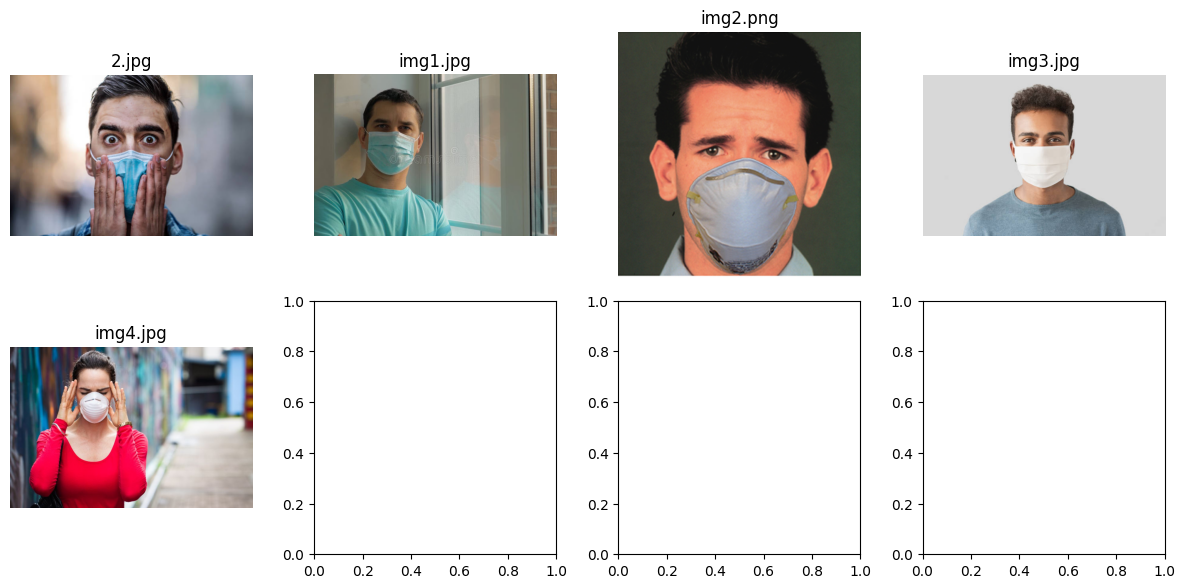

In [70]:
# I visualize the first few test images

from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

# I point to my test images folder
test_dir = Path("test_images")

# I filter out only valid image files
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}
all_paths = sorted(test_dir.iterdir())
image_paths = [p for p in all_paths if p.suffix.lower() in valid_exts]

# I take up to the first eight images
sample_paths = image_paths[:8]

# I plot them in a 2×4 grid
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, img_path in zip(axes.flatten(), sample_paths):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(img_path.name)
    ax.axis("off")
plt.tight_layout()


In [13]:
import torch
from emotion_classifier import EmotionClassifier
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This must match the checkpoint
num_classes = 5

# Instantiate correctly — no weights passed here
model = EmotionClassifier(num_classes=num_classes).to(device)

# Load trained weights
state_dict = torch.load("model.pth", map_location=device)

# Load state_dict
if hasattr(model, "model"):
    missing, unexpected = model.model.load_state_dict(state_dict, strict=False)
else:
    missing, unexpected = model.load_state_dict(state_dict, strict=False)

print(f"Missing keys: {missing}\nUnexpected keys: {unexpected}")

model.eval()
print("✅ Model is ready")


Missing keys: []
Unexpected keys: []
✅ Model is ready


In [16]:
# I set up my preprocessing and run an inference

import torchvision.transforms as T
from PIL import Image

# I define the exact transforms used during training
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

def run_inference(img_path):
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
    return probs

# I test it on the first sample image
img0 = sample_paths[0]
probs = run_inference(img0)
print("Class probabilities:", probs)


Class probabilities: [1.1015289e-03 8.9991462e-01 4.1200109e-03 9.4849311e-02 1.4553639e-05]


In [69]:
from predict import  predict
# I try a custom image

custom_path = "test_images/img2.png"  # ← I’ll update this to my own image path

# I confirm the file exists
import os
assert os.path.exists(custom_path), f"Cannot find file at {custom_path}"

# I run the prediction and print the result
emotion = predict(custom_path)
print(f"Predicted emotion for {custom_path}: {emotion}")


I predict the emotion: 🖼️ neutral
Predicted emotion for test_images/img2.png: neutral
